# Algorítmo de limpieza de potencia aparente de Circuitos

El presente algorítmo permitirá obtener valores de potencia aparente validada para almacenarla en el DWH, la estampa de tiempo de la validación es de 1 minuto.

### Pasos a seguir durante el proceso:

    - Limpieza de outliers con el Método: Local Outlier Factor (LOF)
    - Aplicación del algoritmo de validación de máximos y mínimos
    - Almacenamiento de los datos validados en el DWH

### Limpieza de outliers con el Método: Local Outlier Factor (LOF)

Utilizaremos la biblioreca **sklearn** la cual tiene listo el algoritmo LOF para ser implementado.

In [1]:
### Importación de clases y paquetes

from GetCircuitos import GetCircuitos
from pyspark.sql.functions import to_timestamp, col, regexp_replace
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
#from sklearn.neighbors import LocalOutlierFactor
#from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

#### Obtención de los datos de Circuitos desde el HDFS ( POTENCIA DESTINO)

In [2]:
# Datos de entrada

fecha_inicio = datetime.datetime.strptime('2019-10-10 00:00', '%Y-%m-%d %H:%M')
fecha_fin = datetime.datetime.strptime('2019-10-10 23:59', '%Y-%m-%d %H:%M')
circuito = 'CHG138ELE2'
dimension = 'Potencia Aparente'

# Datos De circuitos (DataFrame Pyspark)

getCircuitos = GetCircuitos(TableName = '', FileName='circuitos_destino_*')
circuitosDestino = getCircuitos.GetDataDestino(fecha_inicio,fecha_fin,circuito)
print(circuitosDestino.columns)
circuitosDestino.select('circuito','TagPotenciaDestino').distinct().show(truncate=False)
tag = circuitosDestino.select('TagPotenciaDestino').distinct().first()[0]

# Datos a pandas dataframe

datosDestino = circuitosDestino.toPandas().set_index('Fecha')

['Id', 'circuito', 'Potencia', 'Calidad', 'TagCalidadDestino', 'TagPotenciaDestino', 'Fecha', 'LimMaxOperacion', 'LimOperacionContinuo', 'LimTermico', 'NumCircuitos']
+----------+--------------------------------+
|circuito  |TagPotenciaDestino              |
+----------+--------------------------------+
|CHG138ELE2|CHONGON138CELEC_2_S.LINEA_CAL.AV|
+----------+--------------------------------+



#### Definición del Algoritmo LOF, salida de datos outliers y datos limpios

In [3]:
# Método LOF

def limpiar_outliers(datos):
    datos_totales = datos.copy()
    #lof = LocalOutlierFactor(n_neighbors=5,contamination = 0.1)
    #iso = IsolationForest(contamination = 0.1, behaviour="new")
    ee = EllipticEnvelope(contamination=0.1)
    y_pred = ee.fit_predict(datos_totales)  
    mascara = y_pred == -1
    outliers = datos_totales[mascara]
    datos_totales = datos_totales[~mascara]
    return outliers, datos_totales

#### Aplicación del Algoritmo LOF

In [4]:
# Limpieza de datos

datos = datosDestino[['Id','Potencia']].copy()
outliers, datos_limpios = limpiar_outliers(datos)

#### Descripción de los datos obtenidos

In [5]:
# Descripcón de los datos de salida

print(datos.describe())
print('================================= Datos')
print(outliers.describe())
print('================================= Ouliers')
print(datos_limpios.describe())
print('================================= Datos Limpios')

          Potencia
count  4000.000000
mean     16.938897
std       5.066852
min       7.444625
25%      10.384142
50%      19.859320
75%      20.345115
max      21.082870
================================= Datos
         Potencia
count  400.000000
mean     8.066268
std      0.164613
min      7.444625
25%      7.992498
50%      8.116223
75%      8.186803
max      8.290216
================================= Ouliers
          Potencia
count  3600.000000
mean     17.924745
std       4.336090
min       8.177746
25%      19.235822
50%      19.986999
75%      20.379944
max      21.082870
================================= Datos Limpios


#### Gráfico para Visualizar los resultados

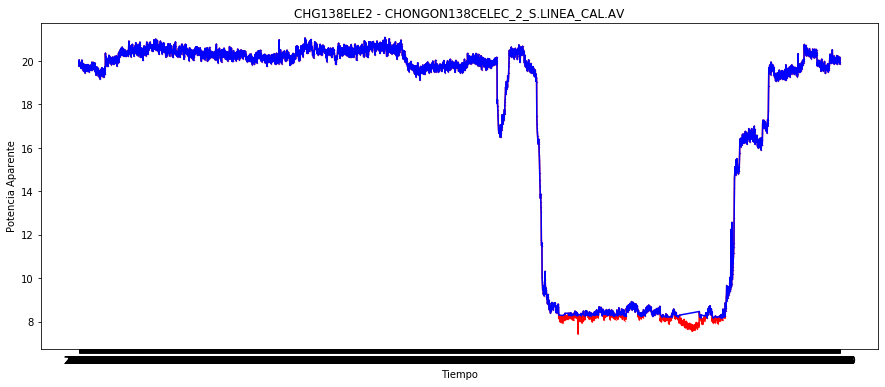

In [6]:
# Presentación de datos sin outliers

plt.plot(datos['Id'],datos['Potencia'],color="red",markersize=0.5,marker='.')
plt.plot(datos_limpios['Id'],datos_limpios['Potencia'],color="blue",markersize=0.5,marker='.')
plt.title(circuito+' - '+tag)
plt.xlabel('Tiempo')
plt.ylabel(dimension)
plt.show()

#### Gráfico BOXPLOT para visualizar los outliers

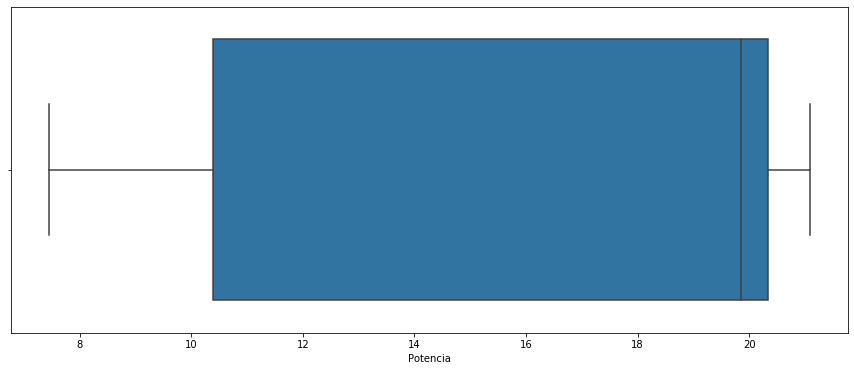

In [7]:
# Diagrama de cajas

sns.boxplot(datos['Potencia'])